In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load and preprocess data
data = load_breast_cancer()
X = data.data[:, :25]
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = normalize(scaler.fit_transform(X_train), norm='l2')
X_test = normalize(scaler.transform(X_test), norm='l2')


STAND_DEV = 0.05
X_train_aug = X_train + np.random.normal(0, STAND_DEV, X_train.shape)
X_train = np.vstack([X_train, X_train_aug])
y_train = np.hstack([y_train, y_train])

# PCA
def pca(X, num_components=5):
    rho = sum(np.outer(x, x) for x in X) / len(X)
    eigvals, eigvecs = np.linalg.eigh(rho)
    return X @ eigvecs[:, -num_components:]

X_train = pca(X_train, 5)
X_test = pca(X_test, 5)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
epochs = 100
l2_lambda = 0.001

# Tracking
metrics = {
    'epoch': [],
    'train_loss': [], 'test_loss': [],
    'train_acc': [], 'test_acc': [],
    'train_prec': [], 'test_prec': [],
    'train_rec': [], 'test_rec': [],
    'train_f1': [], 'test_f1': []
}

# Training
# Print all metrics every 10 epochs
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    l2_reg = sum((p ** 2).sum() for p in model.parameters())
    total_loss = loss + l2_lambda * l2_reg
    total_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        train_pred = (model(X_train) > 0.5).float()
        test_pred = (model(X_test) > 0.5).float()

        train_loss = criterion(model(X_train), y_train).item()
        test_loss = criterion(model(X_test), y_test).item()

        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        train_prec = precision_score(y_train, train_pred, zero_division=0)
        test_prec = precision_score(y_test, test_pred, zero_division=0)
        train_rec = recall_score(y_train, train_pred, zero_division=0)
        test_rec = recall_score(y_test, test_pred, zero_division=0)
        train_f1 = f1_score(y_train, train_pred, zero_division=0)
        test_f1 = f1_score(y_test, test_pred, zero_division=0)

        # Save metrics
        metrics['epoch'].append(epoch+1)
        metrics['train_loss'].append(train_loss)
        metrics['test_loss'].append(test_loss)
        metrics['train_acc'].append(train_acc)
        metrics['test_acc'].append(test_acc)
        metrics['train_prec'].append(train_prec)
        metrics['test_prec'].append(test_prec)
        metrics['train_rec'].append(train_rec)
        metrics['test_rec'].append(test_rec)
        metrics['train_f1'].append(train_f1)
        metrics['test_f1'].append(test_f1)

        # Print all metrics every 10 epochs
        if epoch % 10 == 0:
            print(f"\nEpoch {epoch+1}")
            print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
            print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
            print(f"Train Prec: {train_prec:.4f} | Test Prec: {test_prec:.4f}")
            print(f"Train Recall: {train_rec:.4f} | Test Recall: {test_rec:.4f}")
            print(f"Train F1: {train_f1:.4f} | Test F1: {test_f1:.4f}")



Epoch 1
Train Loss: 0.7026 | Test Loss: 0.7042
Train Acc: 0.3736 | Test Acc: 0.3684
Train Prec: 0.0000 | Test Prec: 0.0000
Train Recall: 0.0000 | Test Recall: 0.0000
Train F1: 0.0000 | Test F1: 0.0000

Epoch 11
Train Loss: 0.5853 | Test Loss: 0.5888
Train Acc: 0.9363 | Test Acc: 0.9123
Train Prec: 0.9369 | Test Prec: 0.9306
Train Recall: 0.9632 | Test Recall: 0.9306
Train F1: 0.9498 | Test F1: 0.9306

Epoch 21
Train Loss: 0.3503 | Test Loss: 0.3673
Train Acc: 0.9637 | Test Acc: 0.9474
Train Prec: 0.9543 | Test Prec: 0.9583
Train Recall: 0.9895 | Test Recall: 0.9583
Train F1: 0.9716 | Test F1: 0.9583

Epoch 31
Train Loss: 0.1372 | Test Loss: 0.1906
Train Acc: 0.9714 | Test Acc: 0.9298
Train Prec: 0.9755 | Test Prec: 0.9571
Train Recall: 0.9789 | Test Recall: 0.9306
Train F1: 0.9772 | Test F1: 0.9437

Epoch 41
Train Loss: 0.0785 | Test Loss: 0.1746
Train Acc: 0.9780 | Test Acc: 0.9298
Train Prec: 0.9774 | Test Prec: 0.9571
Train Recall: 0.9877 | Test Recall: 0.9306
Train F1: 0.9825 | Te

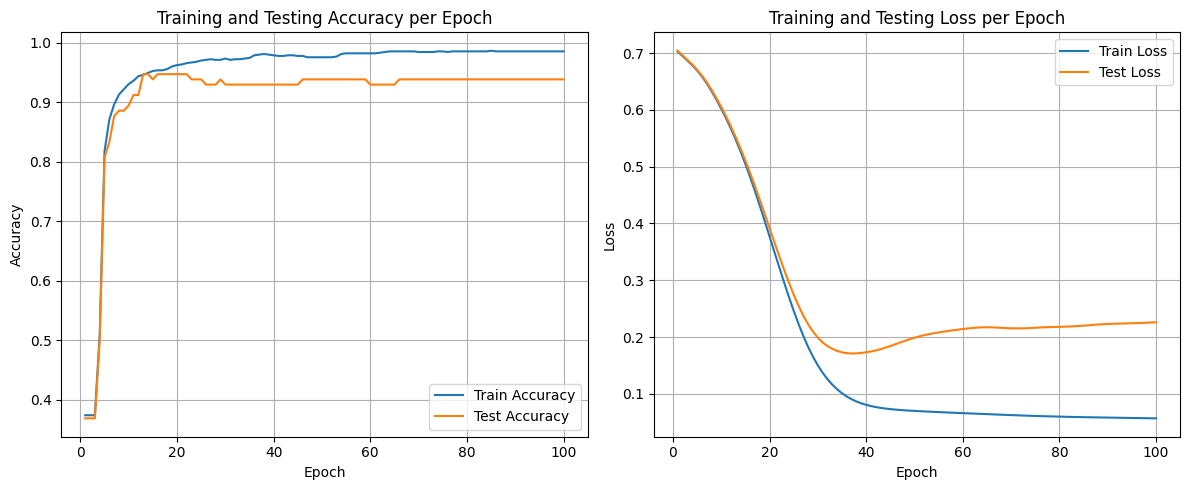

In [3]:
# Convert to DataFrame
df = pd.DataFrame(metrics)

# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy')
plt.plot(df['epoch'], df['test_acc'], label='Test Accuracy')
plt.title('Training and Testing Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['test_loss'], label='Test Loss')
plt.title('Training and Testing Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics_stand_dev_0.05.png')


In [5]:
from sklearn.metrics import classification_report

# Final predictions
model.eval()
with torch.no_grad():
    final_preds = (model(X_test) > 0.5).float().numpy()
    true_labels = y_test.numpy()

# Compute individual metrics
final_acc = accuracy_score(true_labels, final_preds)
final_prec = precision_score(true_labels, final_preds, zero_division=0)
final_rec = recall_score(true_labels, final_preds, zero_division=0)
final_f1 = f1_score(true_labels, final_preds, zero_division=0)

# Print each metric separately
print("\n📌 Final Test Evaluation:")
print(f"Accuracy:  {final_acc:.4f}")
print(f"Precision: {final_prec:.4f}")
print(f"Recall:    {final_rec:.4f}")
print(f"F1 Score:  {final_f1:.4f}")



📌 Final Test Evaluation:
Accuracy:  0.9386
Precision: 0.9710
Recall:    0.9306
F1 Score:  0.9504
